In [1]:
#| echo: false
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from functools import partial

import matplotlib.pyplot as plt

from engression_pytorch import gConcat
from losses import *

A few weeks ago, I wrote about a new method for distributional regression called engression. *Distributional* regression in the sense that it tries to estimate the whole conditional $Y\mid X$ distribution, instead of the usual $\mathbb E[Y\mid X]$. [importance of distributional]

In short, engression estimates the full conditional by considering a generative? model, $g(x, \varepsilon) \mapsto y$, that maps covariates and independent noise to the response. Then, you minimize the negative energy score:

$$
\mathbb E \left[ \left \| Y - g(X, \varepsilon) \right \| - \frac{1}{2} \left \| g(X, \varepsilon) - g(X, \varepsilon') \right \| \right]
$$

where $\varepsilon$ and $\varepsilon'$ are independent draws from a noise distribution. If $\hat g$ has enough capacity and is the/a? minimizer, we can get a sample from the true conditional by sampling iid noise $\varepsilon_1, \dots, \varepsilon_n$ and passing it through $g$: $\{\hat g(x, \varepsilon_i)\}_{i=1}^n$.

The authors show this works for regression, i.e. where Y is real/continious/dense. However, this might not be ideal for classification settings. Perhaps for the same reason that minimizing the brier score is not really practical. distance in one hot emb spaces!

Here we explore adjustments to the engression loss to make it more apt for classification. The majority of them will only be loosely inspired and not contain any of the guarantees provided.

## The engression loss

But first a little more on the loss that will help later on. The first is intuition. The first term is the L2 loss, pushing predictions towards the true response. So far so good. Now, the second term is the L2 distance? between two predictions with different noise draws. That is, it is maximing the distance between predictions obtained with different noise draws. The authors? call it a variance inflating term; it penalizes collapsing all samples to a single point, forcing the model to generate diverse samples.

Secondly, the paper is able to show that we recover the true conditional (with caveates) because the engression loss is the negative energy score, a proper scoring rule that has extensive theory behind it?. 

Third, the authors mention that the energy score is a case of the more general ...

$$
- \mathbb E \left[ k\left(Y - g(X, \varepsilon) \right) - \frac{1}{2} k\left ( g(X, \varepsilon) - g(X, \varepsilon') \right ) \right]
$$

where $k$ is a characteristic kernel (explain). In the engression case $k(z, z') = - \|z - z' \|$, but others are possible ....


## Now for classification

For classification we have that $Y\mid X$ is a categorical distribution. Typically the model, $g$, outputs a distribution over classes and the labels $y$ are onehot encoded. Thus it seems that

In classification, however, we run into problems because ... 


## Experiments

We first play with simple synthetic data and then with CIFAR setups.

Let us say first that $X \sim \text{Unif}(0, 1)$, and $Y\mid X=x \sim \text{Ber}(\text{p}=x)$. We can then have our model be a simple net $g(x, \varepsilon) = W[x ; \varepsilon] + b$ and train it with our losses. 

In [36]:
#| code-summary: Generate data
#| output: false
n = 50_000
k = 2 # no. of classes

# Y|X = x ~ Ber(p = x), i.e. E[Y|X = x] = x, Var[Y|X = x] = x(1 - x)
X = torch.rand(n)
Y = (torch.rand(n) <= X).long()

X, Y = X[:, None], Y[:, None]

dl = DataLoader(TensorDataset(X, Y), batch_size = 1024, shuffle = True)

X.shape, Y.shape, len(dl)

(torch.Size([50000, 1]), torch.Size([50000, 1]), 49)

In [38]:
#| code-summary: Evaluate
@torch.no_grad()
def evaluate(model, dl):
    model.eval()

    total_mean_err = 0
    total_pred_std = 0

    n = len(dl)

    for x, y in dl:
        preds = model(x)
        
        if preds.dim() == 3:  # (batch, m, k)
            probs = F.softmax(preds, dim = -1)[:, :, 1]
        else:  # (batch, k)
            probs = F.softmax(preds, dim = -1)[:, 1][:, None]

        x = x.squeeze()
        true_mean = x
        pred_mean = probs.mean(1)
        mean_err = (pred_mean - true_mean).abs().mean()

        total_mean_err += mean_err.item()
        total_pred_std += probs.std(dim = 1).mean().item()

    return total_mean_err / n, total_pred_std / n

In [ ]:
#| code-summary: Train
def train(cmp = 0, loss_fn = partial(ce_sym_kl, return_components = True), engression = True):

    noise_dim = 15 if engression else 0
    hidden_dim = 64
    model = nn.Sequential(
        nn.Linear(1 + noise_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, k)
    )
    if engression:
        model = gConcat(model, m_train = 4, m_eval = 32, noise_dim = noise_dim)

    opt = torch.optim.Adam(model.parameters(), lr = 1e-2)

    losses, cmp1s, cmp2s = [], [], []
    evals = []

    evals.append(evaluate(model, dl))

    for epoch in range(10):
        for x, y in dl:

            model.train()
            opt.zero_grad()

            output = model(x)
            if engression:
                loss, cmp1, cmp2 = loss_fn(output, y.squeeze())
                l = [loss, cmp1, cmp2][cmp]
            else:
                loss = loss_fn(output, y.squeeze())
                l = loss

            l.backward()
            opt.step()

            losses.append(loss.item())
            cmp1s.append(cmp1.item() if engression else 0)
            cmp2s.append(cmp2.item() if engression else 0)
        
        evals.append(evaluate(model, dl))

    return model, losses, cmp1s, cmp2s, evals

In [46]:
# for loss_fn in [energy_score, js_js, ce_sym_kl, ce_js, ce_sym_ce]:
# loss_fn = partial(js_js, tau = 0.5, return_components = True)
loss_fn = partial(ce_sym_ce, lamb = 0.5, return_components = True)
model, losses, cmp1s, cmp2s, evals = train(loss_fn = partial(loss_fn, return_components = True))

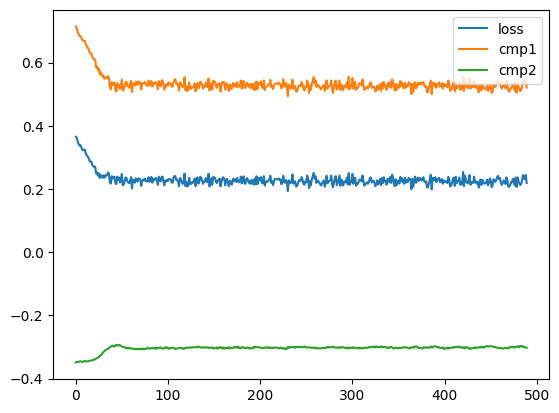

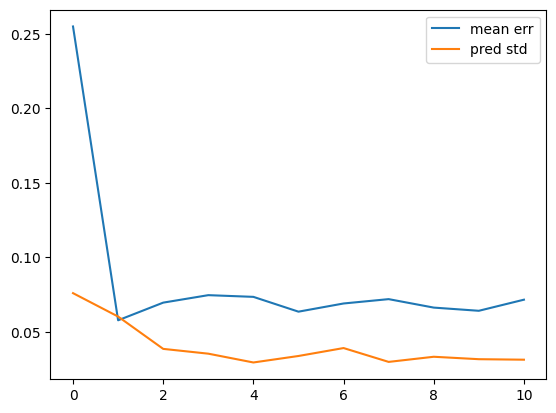

In [47]:
plt.plot(losses, label = 'loss')
plt.plot(cmp1s, label = 'cmp1')
plt.plot(cmp2s, label = 'cmp2')
plt.legend()

plt.figure()
plt.plot([e[0] for e in evals], label = 'mean err')
plt.plot([e[1] for e in evals], label = 'pred std')
plt.legend()

In [44]:
(torch.rand(1000) - 0.5).abs().mean()

tensor(0.2472)

In [94]:
def gen_3class_data(n=5000):
    x = torch.rand(n, 1)
    p0 = 1 - x
    p1 = x * (1 - x)
    p2 = x**2
    p = torch.cat([p0, p1, p2], dim=1)
    p = p / p.sum(dim=1, keepdim=True)
    y = torch.multinomial(p, num_samples=1)
    return x, y, p  # return true probs too

x, y, p = gen_3class_data(5_000)
dl = DataLoader(TensorDataset(x, y, p), batch_size = 1024, shuffle = True)


class SimpleClassifier(nn.Module):
    def __init__(self, noise_dim=8, hidden_dim=32, k=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, k)
        )

    def forward(self, x):
        return self.net(x)
    
@torch.no_grad()
def evaluate3(model, dl):
    model.eval()
    all_preds, all_true = [], []
    stds = []

    for x, _, true_p in dl:

        preds = model(x)
        probs = F.softmax(preds, dim = -1)

        if preds.dim() == 3:  # (batch, m, k)
            probs = probs.mean(1)  # average over m samples
            stds.append(probs.std(dim=1).mean().item())

        all_preds.append(probs)
        all_true.append(true_p)

    pred = torch.cat(all_preds)
    truth = torch.cat(all_true)

    mean_l1 = (pred - truth).abs().mean().item()
    return mean_l1, pred, truth


#| code-summary: Train
def train(cmp = 0, loss_fn = partial(ce_sym_kl, return_components = True), engression = True):

    noise_dim = 15 if engression else 0
    hidden_dim = 128
    model = SimpleClassifier(noise_dim=noise_dim, hidden_dim=hidden_dim, k=3)
    if engression:
        model = gConcat(model, m_train = 4, m_eval = 32, noise_dim = noise_dim)

    opt = torch.optim.Adam(model.parameters(), lr = 1e-2)

    losses, cmp1s, cmp2s = [], [], []
    evals = []

    evals.append(evaluate3(model, dl))

    for epoch in range(20):
        for x, y, _ in dl:

            model.train()
            opt.zero_grad()

            output = model(x)
            if engression:
                loss, cmp1, cmp2 = loss_fn(output, y.squeeze())
                l = [loss, cmp1, cmp2][cmp]
            else:
                loss = loss_fn(output, y.squeeze())
                l = loss

            l.backward()
            opt.step()

            losses.append(loss.item())
            cmp1s.append(cmp1.item() if engression else 0)
            cmp2s.append(cmp2.item() if engression else 0)
        
        evals.append(evaluate3(model, dl))

    return model, losses, cmp1s, cmp2s, evals


# model, losses, cmp1s, cmp2s, evals = train()
model, losses, cmp1s, cmp2s, evals = train(loss_fn = F.cross_entropy, engression = False)

# res = train()
# err, pred_probs, true_probs = evaluate(model, dl)

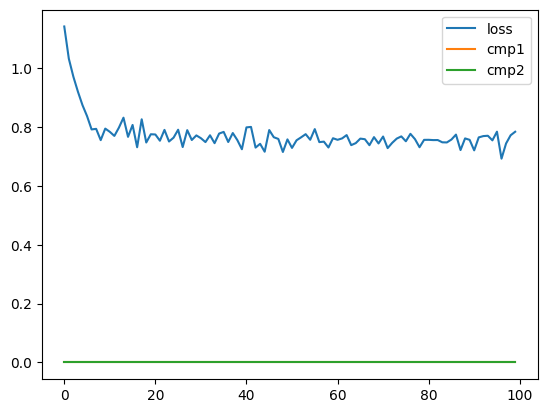

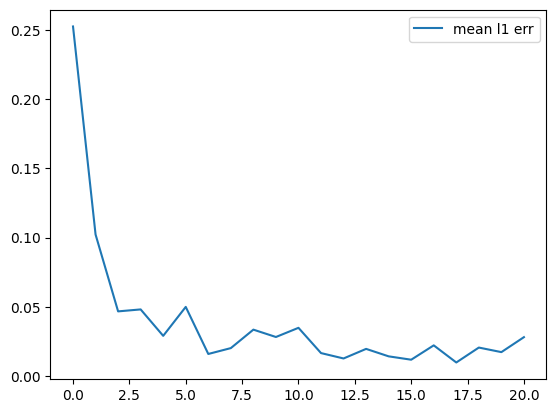

In [97]:
plt.plot(losses, label = 'loss')
plt.plot(cmp1s, label = 'cmp1')
plt.plot(cmp2s, label = 'cmp2')
plt.legend()

plt.figure()
plt.plot([e[0] for e in evals], label = 'mean l1 err')
# plt.plot([e[1] for e in evals], label = 'pred std')
# plt.yscale('log')
plt.legend()

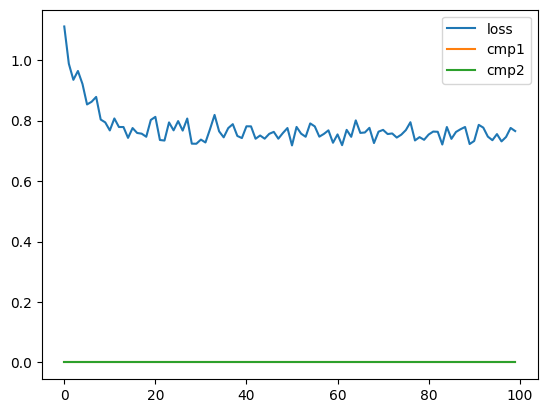

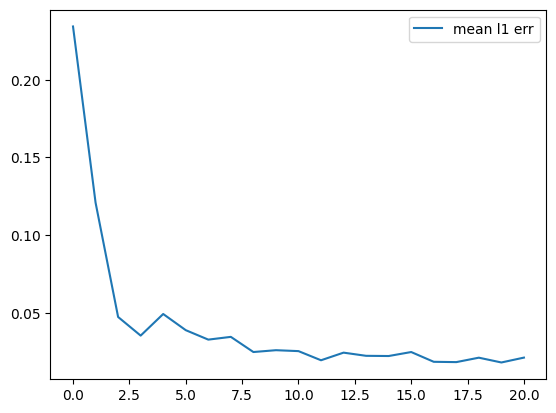

In [88]:
plt.plot(losses, label = 'loss')
plt.plot(cmp1s, label = 'cmp1')
plt.plot(cmp2s, label = 'cmp2')
plt.legend()

plt.figure()
plt.plot([e[0] for e in evals], label = 'mean l1 err')
# plt.plot([e[1] for e in evals], label = 'pred std')
# plt.yscale('log')
plt.legend()

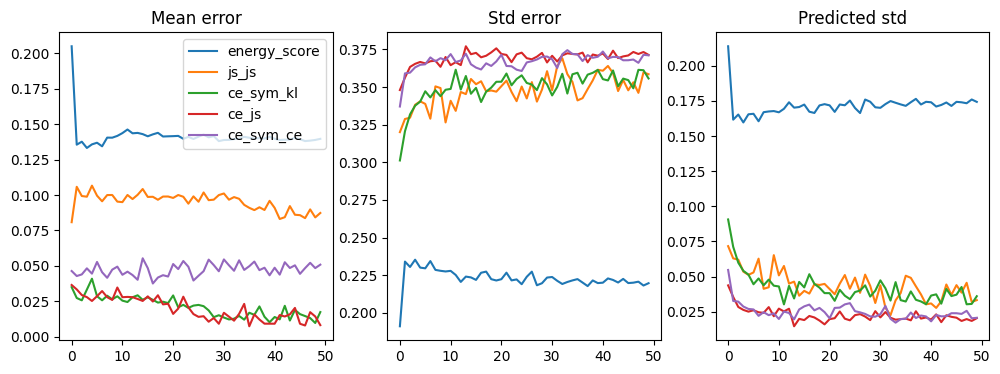

In [64]:
# loss_fn = partial(js_js, lamb = 0.5, tau = 1.0, return_components = True)

f, axs = plt.subplots(1, 3, figsize = (12, 4), sharex = True)

# brier_loss, focal_loss, confidence_penalty_loss


for loss_fn in [energy_score, js_js, ce_sym_kl, ce_js, ce_sym_ce]:

    model, losses, cmp1s, cmp2s, evals = train(loss_fn = partial(loss_fn, return_components = True))

    axs[0].plot([e[0] for e in evals], label = loss_fn.__name__)
    axs[1].plot([e[1] for e in evals], label = loss_fn.__name__)
    axs[2].plot([e[2] for e in evals], label = loss_fn.__name__)

axs[0].set_title('Mean error')
axs[1].set_title('Std error')
axs[2].set_title('Predicted std')

axs[0].legend()

Text(0.5, 0, 'epoch')

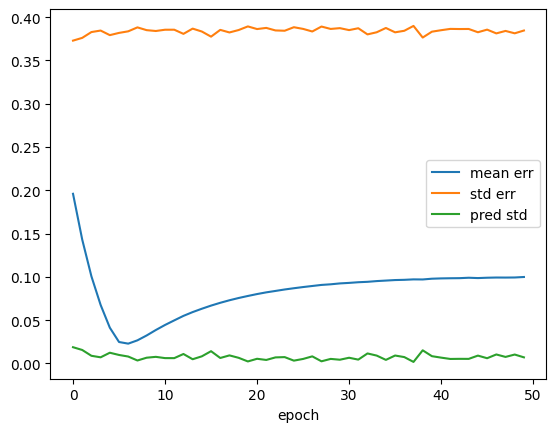

In [28]:
plt.plot([e[0] for e in evals], label = 'mean err')
plt.plot([e[1] for e in evals], label = 'std err')
plt.plot([e[2] for e in evals], label = 'pred std')
plt.legend()
plt.xlabel('epoch')


- footnote: other ways of defining $g$.

## Discussion
- proper is not always best (brier and palin CE).